# Creating images from snapshots

[![Binder](https://mybinder.org/badge_logo.svg)](https://binder.flatironinstitute.org/v2/user/sgenel/CAMELS_PUBLIC?filepath=/Tutorials/Images.ipynb)

Here we will show how to create an image of the gas surface density from a CAMELS snapshot

In [1]:
import numpy as np
import h5py
import hdf5plugin
import camels_library as CL
import MAS_library as MASL
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

Get the name of the snapshot

In [2]:
f_snap = '/home/jovyan/Data/Sims/IllustrisTNG/1P/1P_1_3/snap_033.hdf5'

Open file and read the header

In [3]:
data         = h5py.File(f_snap, 'r')
BoxSize      = data['Header'].attrs[u'BoxSize']/1e3    #size of the snapshot in comoving Mpc/h
redshift     = data['Header'].attrs[u'Redshift']       #reshift of the snapshot
scale_factor = data['Header'].attrs[u'Time']           #scale factor
h            = data['Header'].attrs[u'HubbleParam']    #value of the hubble parameter in 100 km/s/(Mpc/h)
Masses       = data['Header'].attrs[u'MassTable']*1e10 #masses of the particles in Msun/h
Np           = data['Header'].attrs[u'NumPart_Total']  #total number of particles for specie
Omega_m      = data['Header'].attrs[u'Omega0']         #Omega_matter
Omega_L      = data['Header'].attrs[u'OmegaLambda']    #Omega_Lambda

Read the positions and masses of the gas particles

In [4]:
pos_gas  = data['PartType0/Coordinates'][:]/1e3 #Mpc/h
mass_gas = data['PartType0/Masses'][:]*1e10     #Msun/h 

We now assume that each gas particle represents an uniform sphere where its radius is the distance to its closest 32th neighbor. In this cases we are taking into account periodic boundary conditions by setting the size of the box to be BoxSize. Note that we are multiplying that value by a very small number to avoid problems if there are particles just at the edge.

In [5]:
k          = 32   #will compute distance to 32th closest neighbor
threads    = 1    #number of openmp threads
verbose    = True #whether to print some information
radius_gas = CL.KDTree_distance(pos_gas,  pos_gas, k, BoxSize*(1.0+1e-8), threads, verbose) #Mpc/h

Time to build KDTree = 15.161 seconds
Time to find k-neighbors = 231.620 seconds


Lets define the map that will contain the data

In [6]:
grid_size = 256 #the map will contain (grid_size x grid_size) pixels
map_gas   = np.zeros((grid_size, grid_size), dtype=np.float64)

Now lets define the boundaries of our slice

In [7]:
x_min, x_max = 0., BoxSize  #Mpc/h
y_min, y_max = 0., BoxSize  #Mpc/h
z_min, z_max = 0., 5.0      #Mpc/h

Find the particles that are inside the slice

In [8]:
indexes = np.where((pos_gas[:,0]>=x_min) & (pos_gas[:,0]<x_max) &
                   (pos_gas[:,1]>=y_min) & (pos_gas[:,1]<y_max) &
                   (pos_gas[:,2]>=z_min) & (pos_gas[:,2]<z_max))
pos_gas_    = pos_gas[indexes]
mass_gas_   = mass_gas[indexes]
radius_gas_ = (radius_gas[indexes])
print('%.3f < X slice < %.3f'%(np.min(pos_gas_[:,0]), np.max(pos_gas_[:,0])))
print('%.3f < Y slice < %.3f'%(np.min(pos_gas_[:,1]), np.max(pos_gas_[:,1])))
print('%.3f < Z slice < %.3f'%(np.min(pos_gas_[:,2]), np.max(pos_gas_[:,2])))

0.000 < X slice < 25.000
0.000 < Y slice < 25.000
0.000 < Z slice < 5.000


Project the particles along the axis perpendicular to the image

In [9]:
pos_gas_ = pos_gas_[:,[0,1]] #image will show XY plane, so we project along Z axis
pos_gas_ = np.ascontiguousarray(pos_gas_) #This is required for Pylians to speed the calculation up
pos_gas_ = pos_gas_.astype(np.float32)
print(pos_gas_.shape)
print('%.3f < X slice < %.3f'%(np.min(pos_gas_[:,0]), np.max(pos_gas_[:,0])))
print('%.3f < Y slice < %.3f'%(np.min(pos_gas_[:,1]), np.max(pos_gas_[:,1])))

(5555960, 2)
0.000 < X slice < 25.000
0.000 < Y slice < 25.000


In [10]:
tracers     = 1000
r_divisions = 20
periodic    = True
verbose     = True
pos_gas_    = pos_gas_.astype(np.float32)
mass_gas_   = mass_gas_.astype(np.float32)
radius_gas_ = radius_gas_.astype(np.float32)
MASL.projected_voronoi(map_gas, pos_gas_, mass_gas_, radius_gas_, x_min, y_min, BoxSize,
                       tracers, r_divisions, periodic, verbose)

Calculating projected mass of the voronoi tracers...
Time taken = 96.141 s


Check that the mass in the image is the same as in the slice

In [11]:
print('Mass in image: %.3e Msun/h'%(np.sum(map_gas)))
print('Mass in slice: %.3e Msun/h'%(np.sum(mass_gas_)))
print('%.3e < Mass in image < %.3e'%(np.min(map_gas), np.max(map_gas)))

Mass in image: 7.384e+13 Msun/h
Mass in slice: 7.384e+13 Msun/h
2.699e+07 < Mass in image < 4.089e+11


At this point the map contains the gas mass in every pixel. To compute mass surface density divide by area

In [12]:
area_pixel = (BoxSize/grid_size)**2 #(Mpc/h)^2
map_gas /= area_pixel #(Msun/h)/(Mpc/h)^2

Show the image

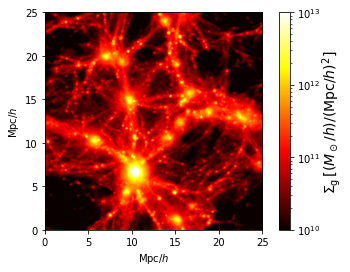

In [13]:
plt.xlabel(r'${\rm Mpc}/h$')
plt.ylabel(r'${\rm Mpc}/h$')
cax = plt.imshow(map_gas,cmap=plt.get_cmap('hot'),origin='lower',
                     interpolation='bicubic',
                     extent=[x_min, x_max, y_min, y_max],
                     norm = LogNorm(vmin=1e10,vmax=1e13))
cbar = plt.colorbar(cax) #in ax2 colorbar of ax1
cbar.set_label(r"$\Sigma_{\rm g}\,[(M_\odot/h)/({\rm Mpc}/h)^2]$",fontsize=14,labelpad=0)